In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import re

sns.set(style="whitegrid")

csv_path = "wandb_data/non-stationary noisynet/"

In [79]:
metrics = ['score', 'regret', 'exploration_rate']

def load_data(folder):
    _data = []
    for _metric in metrics:
        path = f'{csv_path}{folder}{_metric}.csv'
        df = pd.read_csv(path)
        _data.append((df, _metric))
    return _data

data_con200 = load_data('con200/')
data_nn200 = load_data('nn200/')
data_con1000 = load_data('con1000/')
data_nn1000 = load_data('nn1000/')

In [80]:
data_con200[0][0].head(3)

,Step,noisy_net: true - score,noisy_net: true - score__MIN,noisy_net: true - score__MAX
0,50,0.493994,0.248329,0.768083
1,100,0.660834,0.383829,0.790206
2,150,0.732111,0.493028,0.847622


In [81]:
def load_data(folder):
    _data = []
    for _metric in metrics:
        path = f'wandb_data/non-stationary non-noisynet/{folder}{_metric}.csv'
        df = pd.read_csv(path)
        _data.append((df, _metric))
    return _data

non_data_con200 = load_data('con200/')
non_data_nn200 = load_data('nn200/')
non_data_con1000 = load_data('con1000/')
non_data_nn1000 = load_data('nn1000/')

def rename(dataset):
    for df, metric in dataset:
        col_map = ['no', 'no__MIN', 'no__MAX']
        for i in range(3):
            # print(f"Renaming: {df.columns.values[1]} -> {col_map[i]}")
            df[col_map[i]] = df.pop(df.columns.values[1])

rename(non_data_con200)
rename(non_data_nn200)
rename(non_data_con1000)
rename(non_data_nn1000)
non_data_con200[0][0].head(3)

,Step,no,no__MIN,no__MAX
0,50,0.475214,0.205934,0.671368
1,100,0.606728,0.357735,0.759968
2,150,0.676975,0.550666,0.787348


In [82]:
def rename(dataset):
    for df, metric in dataset:
        cols = [
            (f'noisy_net: true - {metric}', 'yes'),
            (f'noisy_net: true - {metric}__MIN', 'yes__MIN'),
            (f'noisy_net: true - {metric}__MAX', 'yes__MAX'),
            (f'noisy_net: false - {metric}', 'no'),
            (f'noisy_net: false - {metric}__MIN', 'no__MIN'),
            (f'noisy_net: false - {metric}__MAX', 'no__MAX'),
        ]
    
        for old, new in cols:
            if old in df.columns:
                df[new] = df.pop(old)
        # df.dropna(subset=['yes__MIN', 'yes__MAX'], inplace=True)

rename(data_con200)
rename(data_nn200)
rename(data_con1000)
rename(data_nn1000)

In [92]:
_combined_data = {}
for i, _metric in enumerate(metrics):
    _df = data_nn1000[i][0]
    _nonoisy_df = non_data_nn1000[i][0]
    combined_df = pd.merge(_df, _nonoisy_df, on='Step', how='outer', suffixes=('', '_no'))
    combined_df = combined_df.sort_values('Step')
    _combined_data[i] = (combined_df, _metric)
    # _combined_data[i] = (pd.concat([_df, _nonoisy_df], axis=1, join="outer"), _metric)
combined_data = list(_combined_data.values())
combined_data[0][0].head()

,Step,yes,yes__MIN,yes__MAX,no,no__MIN,no__MAX
0,50,0.489414,0.301257,0.734509,0.013013,-0.181863,0.193134
1,100,0.632562,0.383829,0.833510,0.132121,-0.098125,0.249718
2,150,0.718855,0.493028,0.844337,0.195850,-0.060541,0.339462
3,200,0.750093,0.536427,0.848152,0.217820,0.010920,0.377238
4,250,0.765034,0.570110,0.871084,0.225149,-0.008435,0.392285


In [93]:
def plot_metric_grid(dataset, suptitle=""):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle(f"{suptitle} Metrics", fontsize=16)

    metric_map = {
        'score':       (0, 'Score', 'Score', 'lower right'),
        'regret':      (1, 'Regret', 'Regret', 'best'),
        'exploration_rate': (2, 'Exploration Rate', 'Exploration Rate', 'upper right'),
    }

    for df, metric in dataset:
        col, title, ylabel, legend_loc = metric_map[metric]
        ax = axes[col]

        sns.lineplot(data=df, x='Step', y='yes', label='NoisyNet', ax=ax)
        sns.lineplot(data=df, x='Step', y='no', label='Non-NoisyNet', ax=ax)
        
        fill_mask = df[['yes__MIN', 'yes__MAX']].notna().all(axis=1)
        ax.fill_between(df['Step'][fill_mask], df['yes__MIN'][fill_mask], df['yes__MAX'][fill_mask], alpha=0.3)
        # ax.fill_between(df['Step'], df['yes__MIN'], df['yes__MAX'], alpha=0.3)
        ax.fill_between(df['Step'], df['no__MIN'], df['no__MAX'], alpha=0.3)

        ax.set_title(f'{metric.capitalize()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(loc=legend_loc)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"results/{suptitle} metrics.png", dpi=300, bbox_inches='tight')
    
    plt.show()

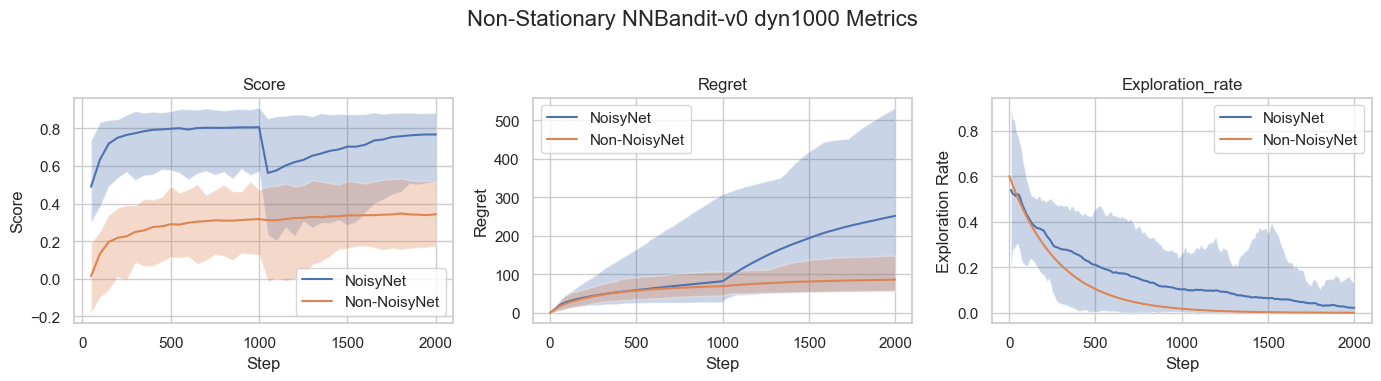

In [94]:
plot_metric_grid(combined_data, suptitle="Non-Stationary NNBandit-v0 dyn1000")

In [ ]:
plot_metric_grid(data_nn200, suptitle="Non-Stationary NNBandit-v0 dyn200")

In [ ]:
plot_metric_grid(data_con1000, suptitle="Non-Stationary ContextualBandit-v2 dyn1000")

In [ ]:
plot_metric_grid(data_nn1000, suptitle="Non-Stationary NNBandit-v0 dyn1000")